# Exploratory Data Analysis of FWI-Reanalysis

## Introduction
The Fire Weather Index (FWI) is a meteorologically based index used worldwide to estimate fire danger. It consists of different components that account for the effects of fuel moisture and wind on fire behaviour and spread. The higher the FWI, the more favorable the meteorological conditions to trigger a wildfire. This indicator can help shape long-term tourist strategy and to plan future investments under a changing climate.

The [`esowc/wildfire-forecasting`](https://github.com/esowc/wildfire-forecasting) project intends to reproduce the Fire Forecasting capabilities of GEFF using Deep Learning and develop further improvements in accuracy, geography and time scale through inclusion of additional variables or optimisation of model architecture & hyperparameters. 

In this notebook we explore the FWI-Reanalysis which is a part of the reanalysis dataset of fire danger indices based on the Canadian Fire Weather Index system and the ECMWF ERA5 reanalysis dataset. Fire danger reanalysis products can be used as proxy for fire weather observations with the advantage of being homogeneously distributed both in space and time. This is further explained in [Vitolo et al (2020)](https://www.nature.com/articles/s41597-020-0554-z).

For the [`esowc/wildfire-forecasting`](https://github.com/esowc/wildfire-forecasting) project, we use FWI-Reanalysis as the ground truth dataset when training our Deep Learning model.

To run this notebook, make sure you have the `wildfire-dl` `conda` environment activated. Instructions for setting up the environment are available in the project [`README`](https://github.com/esowc/wildfire-forecasting/blob/master/README.md).

## Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>
**scipy.stats**: Box-Cox transformation.

In [1]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
from scipy.stats import boxcox
import os

## Getting the data

We first obtain a sample dataset (~`1.5GB` in size). This data is stored on a publicly accessible GCP bucket at `gs://deepfwi-mini-sample` and is downloaded into `data/mini_sample/`

Navigate to the root of the repo

In [2]:
os.chdir('../..')

Getting the data from GCP bucket,

In [3]:
# Uncomment the code below to download data from GCP
# !mkdir data/mini_sample -p
# !gsutil -q cp -r 'gs://deepfwi-mini-sample/*' data/mini_sample

Sample of files we just fetched,

In [4]:
files = glob('data/mini_sample/fwi-reanalysis/*')
files[:4]

['data/mini_sample/fwi-reanalysis/ECMWF_FWI_20191211_1200_hr_fwi_e5.nc',
 'data/mini_sample/fwi-reanalysis/ECMWF_FWI_20191206_1200_hr_fwi_e5.nc',
 'data/mini_sample/fwi-reanalysis/ECMWF_FWI_20191204_1200_hr_fwi_e5.nc',
 'data/mini_sample/fwi-reanalysis/ECMWF_FWI_20191205_1200_hr_fwi_e5.nc']

## Overview

Combining multiple files into single dataarray.

In [5]:
data = xr.open_mfdataset(files).sortby("time").load()

Taking a look.

In [6]:
print(data)

<xarray.Dataset>
Dimensions:  (lat: 640, lon: 1280, time: 10)
Coordinates:
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
  * lon      (lon) float32 0.0 0.28125 0.5625 ... 359.15625 359.4375 359.71875
  * time     (time) datetime64[ns] 2019-12-04 2019-12-05 ... 2019-12-13
Data variables:
    fwi      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Wed Jun 03 12:12:19 2020: cdo --silent -select,name=fw...
    Reference date:    20191211
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...


**Pixel resolution**: *640x1280*<br>
**Longitude resolution**: 0.28125<br>
**Latitude resolution**: 0.278674<br>

Time span of the data,

In [7]:
d_range = [str(v.astype('datetime64[D]')) for v in data.time.values]
f"From {d_range[0]} to {d_range[-1]}"

'From 2019-12-04 to 2019-12-13'

### Visualisation

The FWI values are binned according to the EFFIS categorisation
```
* [0, 5.2]     - Very Low
* (5.2, 11.2]  - Low
* (11.2, 21.3] - Moderate
* (21.3, 38.0] - High
* (38.0, 50.0] - Very High
* (50.0, Inf)  - Extreme
```


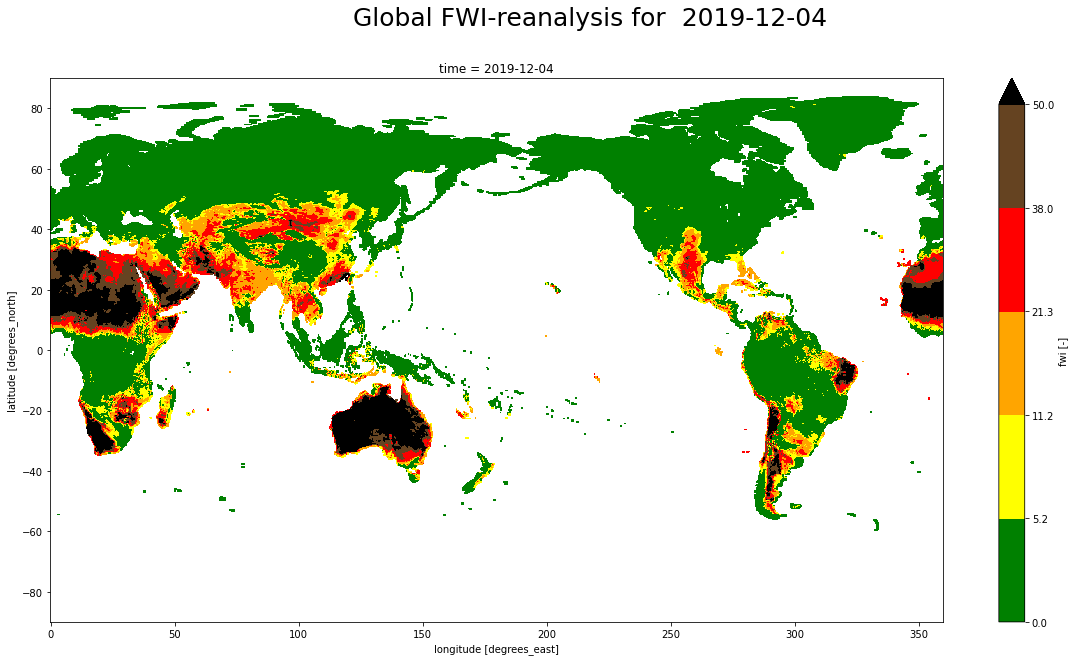

In [8]:
plt.figure(figsize = (20,10)).suptitle(f"Global FWI-reanalysis for  {d_range[0]}", fontsize=25)
data.fwi[0].plot(levels = [0.0, 5.2, 11.2, 21.3, 38.0, 50.0],
                 colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
                 label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme'])

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [9]:
np.isnan(data.fwi[0].values).any()

True

## Overall statistics

During the statistics calculation, the NaN values are skipped.

In [10]:
def npstats(x):
    # For numpy matrices
    tmp = np.nanmean(x)
    print('Mean'.ljust(10), tmp)
    print('MAD'.ljust(10), np.nanmean(np.abs(x-tmp)))
    print('Variance'.ljust(10), np.nanvar(x))
    print('Minimum'.ljust(10), np.nanmin(x))
    print('Maximum'.ljust(10), np.nanmax(x))    

In [11]:
def stats(x):
    # For xarray matrices
    tmp = x.mean(skipna=True).values
    print('Mean'.ljust(10), tmp)
    print('MAD'.ljust(10), abs(x-tmp).mean(skipna=True).values)
    print('Variance'.ljust(10), x.var(skipna=True).values)
    print('Minimum'.ljust(10), x.min(skipna=True).values)
    print('Maximum'.ljust(10), x.max(skipna=True).values)

In [12]:
stats(data.fwi)

Mean       11.6251135
MAD        15.561691
Variance   471.04422
Minimum    1.7413638e-09
Maximum    202.97208


### Frequency distribution

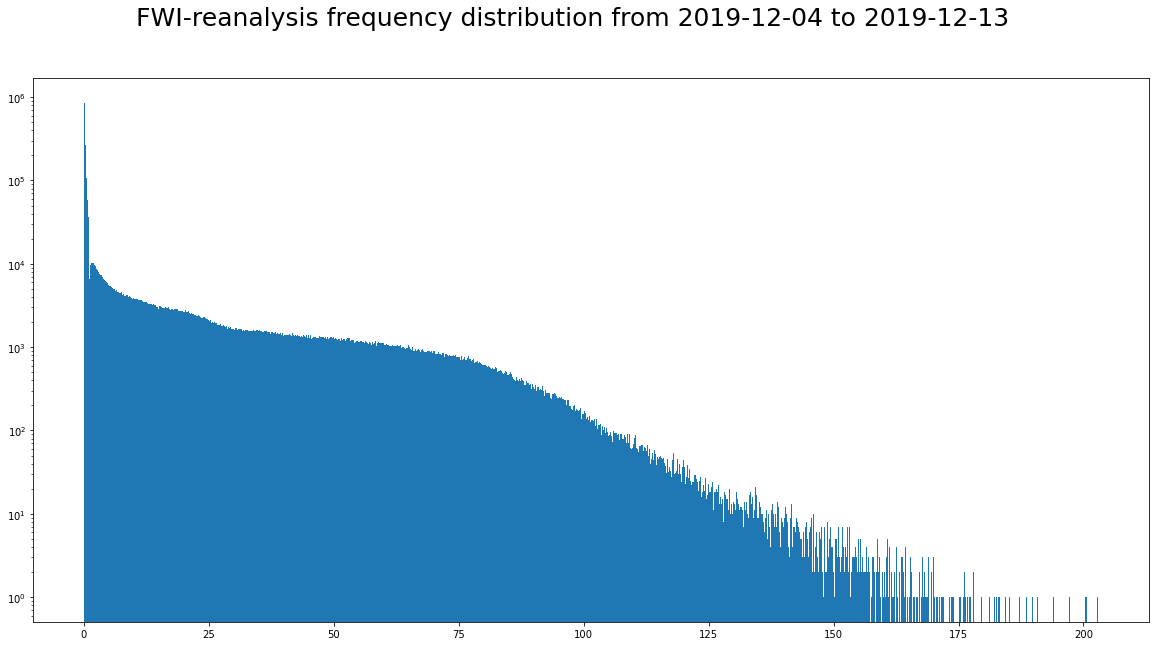

In [13]:
plt.figure(figsize = (20,10)).suptitle(f"FWI-reanalysis frequency distribution from {min(d_range)} to {max(d_range)}", fontsize=25)
plt.hist(data.fwi.values[~np.isnan(data.fwi.values)].flatten(), bins=1000, log=True);

## Data Preprocessing

### Box-Cox transformation

In [14]:
boxcox_fwi, _ = boxcox(data.fwi.values[~np.isnan(data.fwi.values)])

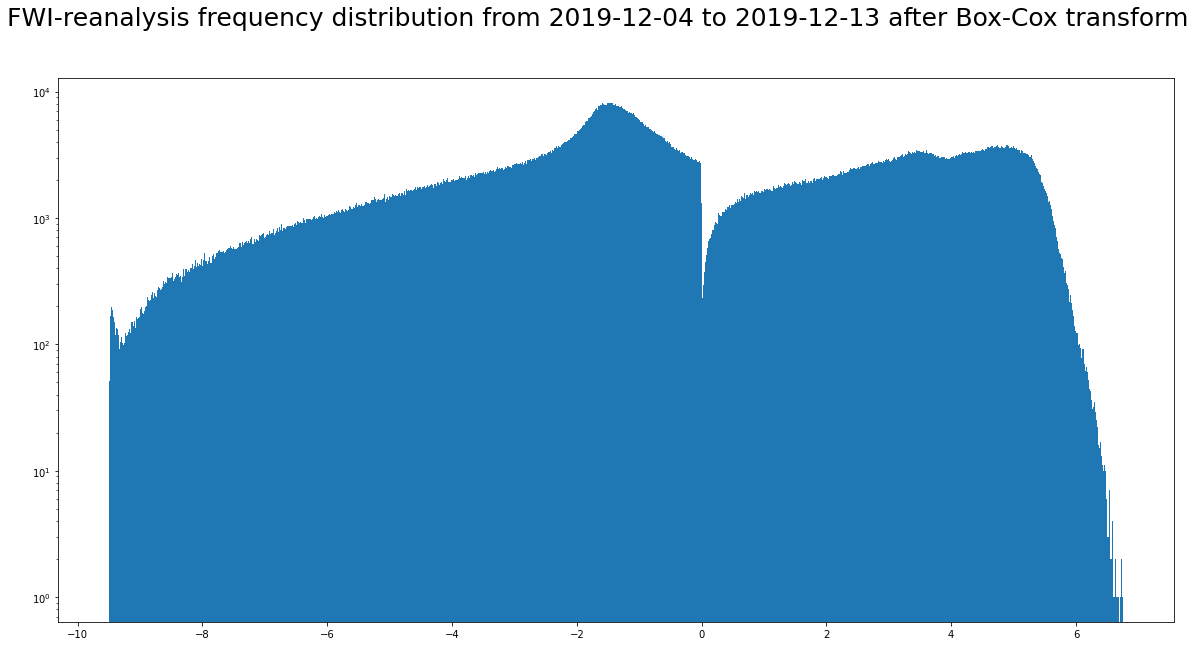

In [15]:
plt.figure(figsize = (20,10)).suptitle(f"FWI-reanalysis frequency distribution from {min(d_range)} to {max(d_range)} after Box-Cox transform", fontsize=25)
plt.hist(boxcox_fwi, bins=1000, log=True);

#### Statistics for Box-Cox transformed FWI,

In [16]:
npstats(boxcox_fwi)

Mean       -0.30457172
MAD        2.850932
Variance   11.743009
Minimum    -9.502021
Maximum    6.755424
